In [2]:
# aankomst rate lambda = 2/3 per minuut
#

In [2]:
# importeren packages
import salabim as sim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import statsmodels.stats.weightstats
import random

In [56]:
kopers = []
eters = []
kopers_afgehaakt = []
eters_afgehaakt = []
omzet_kopers = []
omzet_eters = []
omzet = []
model = []

# genereer klanten
class KlantenGenerator(sim.Component):
    def process(self):
        while True:
            if random.uniform(0,1) <= 0.4:
                Eter()
                stats['eters']+=1
            else:
                Koper()
                stats['kopers']+=1
            self.hold(sim.Exponential(2/3).sample())

# sluit nieuwe klant aan in de wachtrij
class Eter(sim.Component):
    def process(self):
        if Eters_b.requesters().length() < 4:
            self.request(Eters_b)
            self.hold(sim.Normal(9, 1).sample())
            stats['opbrengst_eters']+= sim.Bounded(sim.Normal(20, 2), 0).sample()
        else:
            stats['eters_afgehaakt']+=1
            self.cancel()

# stuur nieuwe webshoporder naar de keuken
class Koper(sim.Component):
    def process(self):
        if Kopers_b.requesters().length() < 3:
            self.request(Kopers_b)
            self.hold(sim.Exponential(2).sample())
            stats['opbrengst_kopers']+= sim.Uniform(3, 7).sample()
        else:
            stats['kopers_afgehaakt']+=1
            self.cancel()

for i in range(200):
    # initialiseer simulatie
    env = sim.Environment(trace=False, random_seed ="*")
    stats = {"kopers": 0, "eters": 0, "kopers_afgehaakt": 0, "eters_afgehaakt": 0, 'opbrengst_eters': 0, 'opbrengst_kopers': 0}

    # simuleer lunchroom
    KlantenGenerator()
    Eters_b = sim.Resource('Eters bediening', capacity=2)
    Kopers_b = sim.Resource('Kopers bediening', capacity=1)



    # run simulatie voor 250000 minuten
    env.run(till=6*60)
    kopers.append(stats['kopers'])
    eters.append(stats['eters'])
    kopers_afgehaakt.append(stats['kopers_afgehaakt'])
    eters_afgehaakt.append(stats['eters_afgehaakt'])
    omzet_kopers.append(stats['opbrengst_kopers'])
    omzet_eters.append(stats['opbrengst_eters'])
    omzet.append(stats['opbrengst_kopers'] + stats['opbrengst_eters'])
    model.append("Huidige")

df1 = pd.DataFrame([kopers, eters, kopers_afgehaakt, eters_afgehaakt, omzet_kopers, omzet_eters, omzet, model]).T
df1 = df1.rename({0: 'Kopers', 1: 'Eters', 2: 'Kopers_afgehaakt', 3: 'Eters_afgehaakt', 4: 'Omzet_kopers', 5: 'Omzet_eters', 6: 'Omzet', 7: 'model'}, axis='columns')

In [47]:
Eters_b.requesters().length_of_stay.mean() + Eters_b.claimers().length_of_stay.mean()

24.269346699057937

In [46]:
Kopers_b.requesters().length_of_stay.mean() + Kopers_b.claimers().length_of_stay.mean()

5.693823160333816

In [45]:
stats

{'kopers': 336,
 'eters': 205,
 'kopers_afgehaakt': 155,
 'eters_afgehaakt': 122,
 'opbrengst_eters': 1543.5536076537735,
 'opbrengst_kopers': 902.796688205553}

In [1]:
# Met mensen in de wachtrij na sluitingstijd nog bedienen
kopers = []
eters = []
kopers_afgehaakt = []
eters_afgehaakt = []
omzet_kopers = []
omzet_eters = []
omzet = []
laatste_klant = []
model = []

# genereer klanten
class KlantenGenerator(sim.Component):
    def process(self):
        while self.env.now() < 6*60:   # alleen klanten genereren zolang de pastaria open is
            if random.uniform(0,1) <= 0.4:  # 40% eters
                Eter()
                stats['eters'] += 1
            else:                           # 60% kopers (webshop orders)
                Koper()
                stats['kopers'] += 1
            # gemiddeld iedere 1.5 minuut nieuwe klant
            self.hold(sim.Exponential(2/3).sample())

# sluit nieuwe klant aan in de wachtrij
class Eter(sim.Component):
    def process(self):
        if Eters_b.requesters().length() < 4:  # max wachtrij = 4
            self.request(Eters_b)
            self.hold(sim.Normal(9, 1).sample())  # eetduur
            omzet = sim.Bounded(sim.Normal(20, 2), 0).sample()
            stats['opbrengst_eters'] += omzet
            stats['laatste_vertrek'] = max(stats['laatste_vertrek'], self.env.now())
        else:
            stats['eters_afgehaakt'] += 1
            self.cancel()

# stuur nieuwe webshoporder naar de keuken
class Koper(sim.Component):
    def process(self):
        if Kopers_b.requesters().length() < 3:  # max wachtrij = 3
            self.request(Kopers_b)
            self.hold(sim.Exponential(2).sample())  # bereidingstijd
            omzet = sim.Uniform(3, 7).sample()
            stats['opbrengst_kopers'] += omzet
            stats['laatste_vertrek'] = max(stats['laatste_vertrek'], self.env.now())
        else:
            stats['kopers_afgehaakt'] += 1
            self.cancel()

# run 200 simulaties
for i in range(200):
    env = sim.Environment(trace=False, random_seed="*")
    stats = {
        "kopers": 0, 
        "eters": 0, 
        "kopers_afgehaakt": 0, 
        "eters_afgehaakt": 0,
        "opbrengst_eters": 0, 
        "opbrengst_kopers": 0,
        "laatste_vertrek": 0
    }

    KlantenGenerator()
    Eters_b = sim.Resource('Eters bediening', capacity=2)
    Kopers_b = sim.Resource('Kopers bediening', capacity=1)

    # run simulatie: geen till → door tot alle klanten klaar zijn
    env.run()

    # resultaten opslaan
    kopers.append(stats['kopers'])
    eters.append(stats['eters'])
    kopers_afgehaakt.append(stats['kopers_afgehaakt'])
    eters_afgehaakt.append(stats['eters_afgehaakt'])
    omzet_kopers.append(stats['opbrengst_kopers'])
    omzet_eters.append(stats['opbrengst_eters'])
    omzet.append(stats['opbrengst_kopers'] + stats['opbrengst_eters'])
    laatste_klant.append(stats['laatste_vertrek'])
    model.append("Pastaria huidig")

# alles in dataframe
df1 = pd.DataFrame([kopers, eters, kopers_afgehaakt, eters_afgehaakt, 
                    omzet_kopers, omzet_eters, omzet, laatste_klant, model]).T

df1 = df1.rename({
    0: 'Kopers', 
    1: 'Eters', 
    2: 'Kopers_afgehaakt', 
    3: 'Eters_afgehaakt', 
    4: 'Omzet_kopers', 
    5: 'Omzet_eters', 
    6: 'Omzet', 
    7: 'Laatste_klant_vertrek',
    8: 'Model'
}, axis='columns')

# toon resultaat
print(df1.head())


  Kopers Eters Kopers_afgehaakt Eters_afgehaakt Omzet_kopers  Omzet_eters  \
0    292   210              111             126   923.994339  1652.284696   
1    321   221              150             138   835.844426  1645.494413   
2    319   221              165             139   765.825825  1652.365531   
3    317   196              139             113   880.601037  1650.743311   
4    319   228              141             142   874.046843  1748.578267   

         Omzet Laatste_klant_vertrek            Model  
0  2576.279036            382.737504  Pastaria huidig  
1  2481.338839            380.674982  Pastaria huidig  
2  2418.191357            381.024266  Pastaria huidig  
3  2531.344348              374.6367  Pastaria huidig  
4  2622.625111            380.197683  Pastaria huidig  


In [55]:
df1 = df1.astype({c:'float64' for c in df1.columns if c != 'model'})
df1.describe()

,Kopers,Eters,Kopers_afgehaakt,Eters_afgehaakt,Omzet_kopers,Omzet_eters,Omzet
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,323.335000,216.640000,150.450000,132.550000,848.951014,1573.156488,2422.107502
std,16.599412,14.296586,19.777341,14.283121,59.563248,28.576474,62.931999
min,282.000000,177.000000,98.000000,93.000000,689.536318,1493.562887,2258.840474
25%,311.000000,207.000000,137.000000,123.000000,810.752644,1552.784817,2371.158325
50%,324.000000,217.000000,150.000000,134.000000,848.192253,1572.646022,2426.755188
75%,336.000000,226.000000,166.250000,141.000000,884.901438,1593.197054,2464.093479
max,363.000000,252.000000,202.000000,167.000000,988.308055,1648.763954,2605.161898


# Variant A

In [57]:
kopers = []
eters = []
kopers_afgehaakt = []
eters_afgehaakt = []
omzet_kopers = []
omzet_eters = []
omzet = []
model = []

# genereer klanten
class KlantenGenerator(sim.Component):
    def process(self):
        while True:
            if random.uniform(0,1) <= 0.4:
                Eter()
                stats['eters']+=1
            else:
                Koper()
                stats['kopers']+=1
            self.hold(sim.Exponential(2/3).sample())

# sluit nieuwe klant aan in de wachtrij
class Eter(sim.Component):
    def process(self):
        if Eters_b.requesters().length() < 4:
            self.request(Eters_b)
            self.hold(sim.Normal(9, 1).sample())
            stats['opbrengst_eters']+= sim.Bounded(sim.Normal(20, 2), 0).sample()
        else:
            stats['eters_afgehaakt']+=1
            self.cancel()

# stuur nieuwe webshoporder naar de keuken
class Koper(sim.Component):
    def process(self):
        if Kopers_b.requesters().length() < 3:
            self.request(Kopers_b)
            self.hold(sim.Exponential(2).sample())
            stats['opbrengst_kopers']+= sim.Uniform(3, 7).sample()
        else:
            stats['kopers_afgehaakt']+=1
            self.cancel()
            
for i in range(200):
    # initialiseer simulatie
    env = sim.Environment(trace=False, random_seed ="*")
    stats = {"kopers": 0, "eters": 0, "kopers_afgehaakt": 0, "eters_afgehaakt": 0, 'opbrengst_eters': 0, 'opbrengst_kopers': 0}

    # simuleer lunchroom
    KlantenGenerator()
    Eters_b = sim.Resource('Eters bediening', capacity=2)
    Kopers_b = sim.Resource('Kopers bediening', capacity=1)



    # run simulatie voor 250000 minuten
    env.run(till=8*60)
    kopers.append(stats['kopers'])
    eters.append(stats['eters'])
    kopers_afgehaakt.append(stats['kopers_afgehaakt'])
    eters_afgehaakt.append(stats['eters_afgehaakt'])
    omzet_kopers.append(stats['opbrengst_kopers'])
    omzet_eters.append(stats['opbrengst_eters'])
    omzet.append(stats['opbrengst_kopers'] + stats['opbrengst_eters'])
    model.append("VartiantA")

df2 = pd.DataFrame([kopers, eters, kopers_afgehaakt, eters_afgehaakt, omzet_kopers, omzet_eters, omzet, model]).T
df2 = df2.rename({0: 'Kopers', 1: 'Eters', 2: 'Kopers_afgehaakt', 3: 'Eters_afgehaakt', 4: 'Omzet_kopers', 5: 'Omzet_eters', 6: 'Omzet', 7: 'model'}, axis='columns')

In [20]:
Eters_b.requesters().length_of_stay.mean() + Eters_b.claimers().length_of_stay.mean()

24.355098435580615

In [21]:
Kopers_b.requesters().length_of_stay.mean() + Kopers_b.claimers().length_of_stay.mean()

5.749235833597306

In [22]:
stats

{'kopers': 433,
 'eters': 277,
 'kopers_afgehaakt': 187,
 'eters_afgehaakt': 167,
 'opbrengst_eters': 2102.0599546548106,
 'opbrengst_kopers': 1227.2372671537528}

# Variant B

In [58]:
kopers = []
eters = []
kopers_afgehaakt = []
eters_afgehaakt = []
omzet_kopers = []
omzet_eters = []
omzet = []
model = []
# genereer klanten
class KlantenGenerator(sim.Component):
    def process(self):
        while True:
            if random.uniform(0,1) <= 0.4:
                Eter()
                stats['eters']+=1
            else:
                Koper()
                stats['kopers']+=1
            self.hold(sim.Exponential(2/3).sample())

# sluit nieuwe klant aan in de wachtrij
class Eter(sim.Component):
    def process(self):
        if Eters_b.requesters().length() < 2:
            self.request(Eters_b)
            self.hold(sim.Normal(9, 1).sample())
            stats['opbrengst_eters']+= sim.Bounded(sim.Normal(20, 2), 0).sample()
        else:
            stats['eters_afgehaakt']+=1
            self.cancel()

# stuur nieuwe webshoporder naar de keuken
class Koper(sim.Component):
    def process(self):
        if Kopers_b.claimers().length() < 4:
            self.request(Kopers_b)
            self.hold(sim.Exponential(2).sample())
            stats['opbrengst_kopers']+= sim.Uniform(3, 7).sample()
        else:
            stats['kopers_afgehaakt']+=1
            self.cancel()

for i in range(200):
    # initialiseer simulatie
    env = sim.Environment(trace=False, random_seed ="*")
    stats = {"kopers": 0, "eters": 0, "kopers_afgehaakt": 0, "eters_afgehaakt": 0, 'opbrengst_eters': 0, 'opbrengst_kopers': 0}

    # simuleer lunchroom
    KlantenGenerator()
    Eters_b = sim.Resource('Eters bediening', capacity=4)
    Kopers_b = sim.Resource('Kopers bediening', capacity=4)



    # run simulatie voor 250000 minuten
    env.run(till=6*60)
    kopers.append(stats['kopers'])
    eters.append(stats['eters'])
    kopers_afgehaakt.append(stats['kopers_afgehaakt'])
    eters_afgehaakt.append(stats['eters_afgehaakt'])
    omzet_kopers.append(stats['opbrengst_kopers'])
    omzet_eters.append(stats['opbrengst_eters'])
    omzet.append(stats['opbrengst_kopers'] + stats['opbrengst_eters'])
    model.append("VariantB")

df3 = pd.DataFrame([kopers, eters, kopers_afgehaakt, eters_afgehaakt, omzet_kopers, omzet_eters, omzet, model]).T
df3 = df3.rename({0: 'Kopers', 1: 'Eters', 2: 'Kopers_afgehaakt', 3: 'Eters_afgehaakt', 4: 'Omzet_kopers', 5: 'Omzet_eters', 6: 'Omzet', 7: 'model'}, axis='columns')

In [29]:
Eters_b.requesters().length_of_stay.mean() + Eters_b.claimers().length_of_stay.mean()

11.317820771202488

In [30]:
Kopers_b.requesters().length_of_stay.mean() + Kopers_b.claimers().length_of_stay.mean()

2.0855456035474274

In [31]:
stats

{'kopers': 352,
 'eters': 246,
 'kopers_afgehaakt': 38,
 'eters_afgehaakt': 88,
 'opbrengst_eters': 3072.074953016484,
 'opbrengst_kopers': 1515.80570806338}

# Variant C

In [59]:
kopers = []
eters = []
kopers_afgehaakt = []
eters_afgehaakt = []
omzet_kopers = []
omzet_eters = []
omzet = []
model = []
# genereer klanten
class KlantenGenerator(sim.Component):
    def process(self):
        while True:
            if random.uniform(0,1) <= 0.4:
                Eter()
                stats['eters']+=1
            else:
                Koper()
                stats['kopers']+=1
            self.hold(sim.Exponential(2/3).sample())

# sluit nieuwe klant aan in de wachtrij
class Eter(sim.Component):
    def process(self):
        if Eters_b.claimers().length() < 6:
            self.request(Eters_b)
            self.hold(sim.Normal(9, 1).sample())
            stats['opbrengst_eters']+= sim.Bounded(sim.Normal(20, 2), 0).sample()
        else:
            stats['eters_afgehaakt']+=1
            self.cancel()

# stuur nieuwe webshoporder naar de keuken
class Koper(sim.Component):
    def process(self):
        if Kopers_b.requesters().length() < 2:
            self.request(Kopers_b)
            self.hold(sim.Exponential(2).sample())
            stats['opbrengst_kopers']+= sim.Uniform(3, 7).sample()
        else:
            stats['kopers_afgehaakt']+=1
            self.cancel()
            
for i in range(200):
    # initialiseer simulatie
    env = sim.Environment(trace=False, random_seed ="*")
    stats = {"kopers": 0, "eters": 0, "kopers_afgehaakt": 0, "eters_afgehaakt": 0, 'opbrengst_eters': 0, 'opbrengst_kopers': 0}

    # simuleer lunchroom
    KlantenGenerator()
    Eters_b = sim.Resource('Eters bediening', capacity=6)
    Kopers_b = sim.Resource('Kopers bediening', capacity=2)



    # run simulatie voor 250000 minuten
    env.run(till=6*60)
    kopers.append(stats['kopers'])
    eters.append(stats['eters'])
    kopers_afgehaakt.append(stats['kopers_afgehaakt'])
    eters_afgehaakt.append(stats['eters_afgehaakt'])
    omzet_kopers.append(stats['opbrengst_kopers'])
    omzet_eters.append(stats['opbrengst_eters'])
    omzet.append(stats['opbrengst_kopers'] + stats['opbrengst_eters'])
    model.append("VariantC")

df4 = pd.DataFrame([kopers, eters, kopers_afgehaakt, eters_afgehaakt, omzet_kopers, omzet_eters, omzet, model]).T
df4 = df4.rename({0: 'Kopers', 1: 'Eters', 2: 'Kopers_afgehaakt', 3: 'Eters_afgehaakt', 4: 'Omzet_kopers', 5: 'Omzet_eters', 6: 'Omzet', 7: 'model'}, axis='columns')

In [37]:
Eters_b.requesters().length_of_stay.mean() + Eters_b.claimers().length_of_stay.mean()

8.860221293935357

In [38]:
Kopers_b.requesters().length_of_stay.mean() + Kopers_b.claimers().length_of_stay.mean()


2.5360646369331556

In [41]:
stats

{'kopers': 319,
 'eters': 214,
 'kopers_afgehaakt': 46,
 'eters_afgehaakt': 51,
 'opbrengst_eters': 3194.5551969340004,
 'opbrengst_kopers': 1378.6032062081588}

# Kosten terugverdienst-praktijken

In [66]:
huidig_omzet = np.mean(df1['Omzet'])
varianta_omzet = np.mean(df2['Omzet'])
variantb_omzet = np.mean(df3['Omzet'])
variantc_omzet = np.mean(df4['Omzet'])

verschil_a = varianta_omzet - huidig_omzet
verschil_b = variantb_omzet - huidig_omzet
verschil_c = variantc_omzet - huidig_omzet

dagen_a = 60000/verschil_a
dagen_b = 120000 / verschil_b
dagen_c = 150000 / verschil_c

print(dagen_a, dagen_b, dagen_c)

72.32771081462359 59.710884824902436 68.65952409808902


In [68]:
verschil = [df3['Omzet'] - df1['Omzet']]

<Axes: ylabel='Count'>

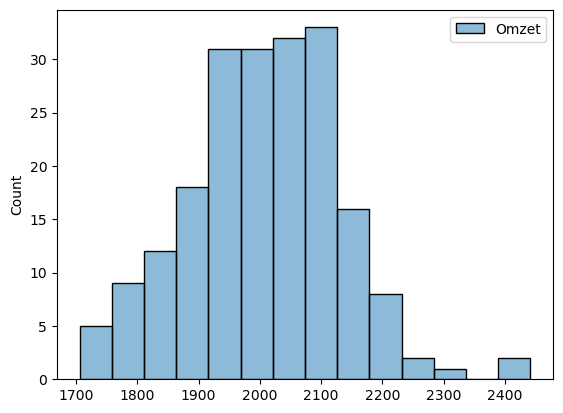

In [69]:
sns.histplot(verschil)

In [73]:
import numpy as np
import pandas as pd
from scipy import stats

# 1) Verschil als float en opschonen
verschil = pd.to_numeric(df3['Omzet'], errors='coerce') - pd.to_numeric(df1['Omzet'], errors='coerce')
x = verschil.to_numpy(dtype='float64')

# Drop NaN/inf
x = x[np.isfinite(x)]
n = x.size
sd = x.std(ddof=1) if n > 1 else np.nan

print(f"n={n}, mean={x.mean():.3f}" if n else "Geen data over na opschonen.")

results = {}

# 2) Shapiro–Wilk (3 <= n <= 5000)
if 3 <= n <= 5000:
    sw_stat, sw_p = stats.shapiro(x)
    results['Shapiro'] = (sw_stat, sw_p)

# 3) D’Agostino & Pearson K² (n >= 8)
if n >= 8:
    k2_stat, k2_p = stats.normaltest(x, nan_policy='omit')
    results["D'Agostino K²"] = (k2_stat, k2_p)

# 4) Anderson–Darling (altijd ok)
ad_res = stats.anderson(x, dist='norm')
results['Anderson'] = (ad_res.statistic, list(ad_res.critical_values), list(ad_res.significance_level))

# 5) KS op genormaliseerde data (alleen als sd>0)
if n >= 3 and np.isfinite(sd) and sd > 0:
    z = (x - x.mean()) / sd
    ks_stat, ks_p = stats.kstest(z, 'norm')
    results['KS (z~N(0,1))'] = (ks_stat, ks_p)

# 6) Netjes printen
for name, val in results.items():
    if name == 'Anderson':
        stat, crit, sig = val
        print(f"{name}: stat={stat:.3f}, critical={crit}, siglvl={sig}")
    else:
        stat, p = val
        print(f"{name}: stat={stat:.3f}, p={p:.4f}")

# (optioneel) snelle interpretatie:
def interpret_p(p): return "geen bewijs tégen normaliteit" if p >= 0.05 else "verwerp normaliteit"
if 'Shapiro' in results:
    print("Shapiro:", interpret_p(results['Shapiro'][1]))
if "D'Agostino K²" in results:
    print("D’Agostino:", interpret_p(results["D'Agostino K²"][1]))
if 'KS (z~N(0,1))' in results:
    print("KS:", interpret_p(results['KS (z~N(0,1))'][1]))


n=200, mean=2009.684
Shapiro: stat=0.989, p=0.1135
D'Agostino K²: stat=2.389, p=0.3028
Anderson: stat=0.434, critical=[0.565, 0.644, 0.772, 0.901, 1.071], siglvl=[15.0, 10.0, 5.0, 2.5, 1.0]
KS (z~N(0,1)): stat=0.047, p=0.7393
Shapiro: geen bewijs tégen normaliteit
D’Agostino: geen bewijs tégen normaliteit
KS: geen bewijs tégen normaliteit


In [74]:
# gemiddelde en standaardfout van verschil
mean_diff = np.mean(df3['Omzet']) - np.mean(df1['Omzet'])
se_diff   = np.sqrt(np.var(df3['Omzet'], ddof=1)/len(df3) +
                    np.var(df1['Omzet'], ddof=1)/len(df1))

# 95% CI van verschil
z = 1.96
ci_diff = (mean_diff - z*se_diff, mean_diff + z*se_diff)

# omzet naar dagen
ci_dagen = (120000/ci_diff[1], 120000/ci_diff[0])  # let op: omgekeerd delen!
print("95% CI dagen_b:", ci_dagen)


95% CI dagen_b: (59.21242419802224, 60.21780895795519)


In [80]:
verschil

0      2044.215122
1      2101.242474
2      1908.719963
3      2012.339960
4      1930.157040
          ...     
195    2117.999719
196    1779.746839
197    2056.110912
198    2150.310736
199    2056.398008
Name: Omzet, Length: 200, dtype: float64

> Slimmme dingen zeggen over CLT en normaal verdeling enzo + grafiekje behouden en uitleggen dat we daarom simpele manier de 95CI mogen berekenen